# Project 12: Bot Playing "Dixit" Board Game

An agent capable of playing "Dixit" may be created by combining a CLIP-like model for image understanding with a large language model (LLM) for generating and interpreting creative descriptions. We want an agent capable of playing both roles in Dixit: who guesses and who gives the hint.

In this project, you will:
- Develop a bot to play Dixit, based
on a pre-trained CLIP-like model to
interpret images and a LLM to
generate descriptions (GPT APIs
are fine).
- Conduct experiments to compare the bot's performance against GPT-4o multimodal and
humans in >10 games.

Hashtags: #generative-AI, #multimodal-models

<br>

---

<br>

### Outline:

1. Utility functions
2. Import images
3. Role 1: the storyteller. Select an image and generate a creative, concise description for it.
4. [Role 2: who guesses]
5. [*Bonus*] Implement the cards selection and points assignment mechanisms, creating a raw but real demo of the game

<br>

---

<br>

#### Dixit images

How does Dixit work?

**Game set-up:** shuffle the cards and give 6 of them to each player. The cards dealt should not be seen by other players. Make a draw pile with the remaining cards. The players then take the following roles.

**The storyteller:** one player is the storyteller for the turn. He makes up a short sentence (even just a word) for one of the cards in his hand and says it out loud, without showing the chosen card. Then, the other players select amongst their images the one that best matches the definition given by the storyteller and put it covered at the center of the table, where they get shuffled.

**The guesser:** the goal of each other player is to find the storyteller's original card among the ones revealed in each turn. They have to guess, one at a time, and secretly vote for the card that they think matches best the definition. Once everyone has voted, the guesses are revealed and the storyteller indicates his/her original card. Based on how many players put their bet on which card, points are assigned and players advance on the scoreboard.

(for now, we'll ignore the voting tokens and the points mechanism)

In [5]:
import os
import random
import matplotlib.pyplot as plt
from matplotlib.image import imread

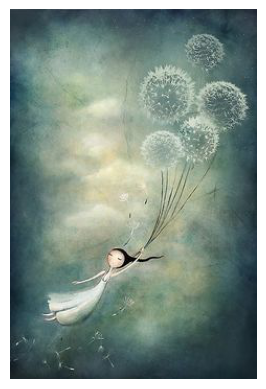

In [34]:
fig = plt.figure()
img = imread(".\cards\card_00001.jpg")
plt.imshow(img);
plt.axis('off');

In [43]:
def plot_random_images(folder = ".\cards", n = 4, seed = None):
 
    '''
    Function that displays n images chosen at random from the specified folder.
    '''

    # Open the folder and handle errors
    try:
        image_list = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    except FileNotFoundError:
        print(f"[ERROR]: folder '{folder}' not found!")
        return

    if not image_list: # use lists' implicit booleanness
        print(f"[WARNING]: the folder '{folder}' is empty.")
        return
    num_images = min(n, len(image_list))

    if seed:
        random.seed(seed)
    random_images = random.sample(image_list, num_images)

    # Plot
    cols = min(4, n)
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize = (15, 5))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < n:
            img_path = os.path.join(folder, random_images[i])
            img = imread(img_path)
            ax.imshow(img)
            ax.set_title(random_images[i])
            ax.axis('off')
        else:
            ax.axis('off')

    fig.suptitle('Some random images', fontsize = 20)
    plt.tight_layout()
    plt.show()
    return

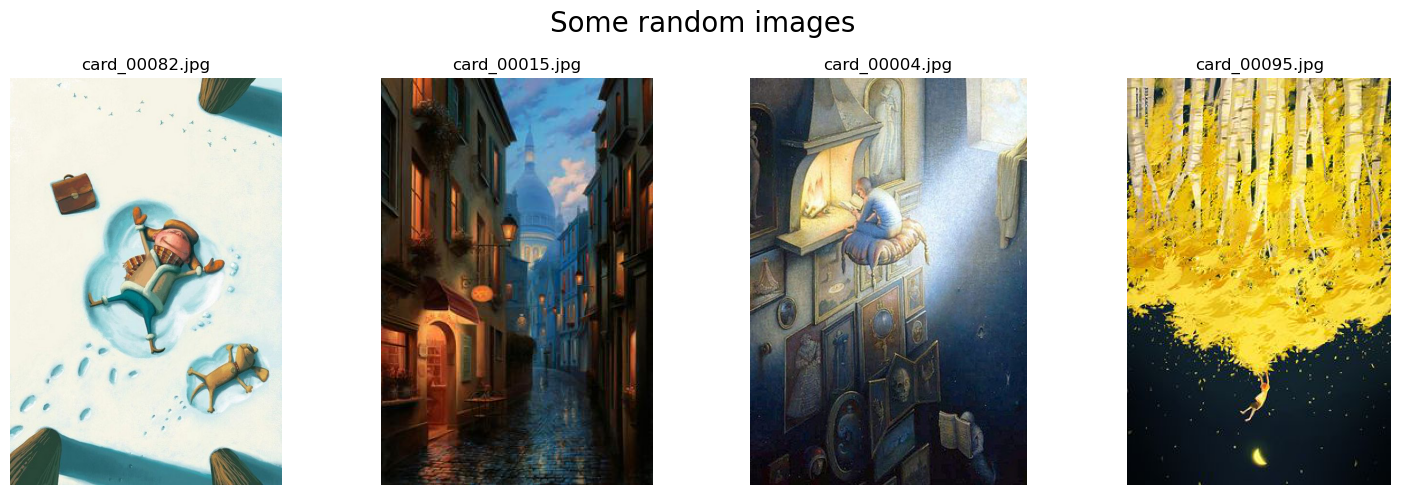

In [46]:
plot_random_images(seed = 42)

#### CLIP

CLIP (Contrastive Language-Image Pre-Training) is a neural network trained on a variety of (image, text) pairs. It can be instructed in natural language to predict the most relevant text snippet, given an image, without directly optimizing for the task.

https://github.com/openai/CLIP

In [5]:
import torch
print(torch.__version__)

1.13.1+cpu


In [ ]:
! pip install torchvision

  Using cached torchvision-0.20.1-cp39-cp39-win_amd64.whl (1.6 MB)
     -------------------------------------- 203.0/203.0 MB 3.3 MB/s eta 0:00:00
  Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
  Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.4.0
    Can't uninstall 'typing-extensions'. No files were found to uninstall.
  Attempting uninstall: sympy
    Found existing installation: sympy 1.11.1
    Can't uninstall 'sympy'. No files were found to uninstall.
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1
    Uninstalling torch-1.13.1:


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'c:\\users\\cristiana\\anaconda3\\lib\\site-packages\\functorch\\'



     ---------------------------------------- 1.6/1.6 MB 4.1 MB/s eta 0:00:00
     -------------------------------------- 203.0/203.0 MB 1.4 MB/s eta 0:00:00
  Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
     ---------------------------------------- 6.2/6.2 MB 2.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0
  Attempting uninstall: sympy
    Found existing installation: sympy 1.11.1
    Uninstalling sympy-1.11.1:
      Successfully uninstalled sympy-1.11.1
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1
    Uninstalling torch-1.13.1:


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'c:\\users\\cristiana\\anaconda3\\lib\\site-packages\\torch\\lib\\asmjit.dll'
Consider using the `--user` option or check the permissions.



In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ---------------------------------------- 44.8/44.8 kB 1.1 MB/s eta 0:00:00


  Cloning https://github.com/openai/CLIP.git to c:\users\cristiana\appdata\local\temp\pip-req-build-t5tif2gd
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached torch-2.5.1-cp39-cp39-win_amd64.whl (203.0 MB)
  Using cached torchvision-0.20.1-cp39-cp39-win_amd64.whl (1.6 MB)
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369566 sha256=230ac074c16ccf607a6b15e99ff540a3c1dadba8242ab9bd98b7668ca8b21eb8
  Stored in directory: C:\Users\Cristiana\AppData\Local\Temp\pip-ephem-wheel-cache-6qqbt2ol\wheels\c8\e4\e1\11374c111387672fc2068dfbe0d4b424cb9cdd1b2e184a71b5
Successfully built clip


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\Cristiana\AppData\Local\Temp\pip-req-build-t5tif2gd'
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Cristiana\\anaconda3\\Lib\\site-packages\\torch\\lib\\uv.dll'
Consider using the `--user` option or check the permissions.



In [16]:
! pip install torch==2.2

     -------------------------------------- 198.5/198.5 MB 3.5 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.5.1
    Uninstalling torch-2.5.1:
      Successfully uninstalled torch-2.5.1


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Cristiana\\AppData\\Local\\Temp\\pip-uninstall-9t_70m74\\lib\\asmjit.dll'
Consider using the `--user` option or check the permissions.



In [18]:
# Use the HuggingFace implementation
from PIL import Image
import requests

In [19]:
from transformers import CLIPProcessor, CLIPModel

AttributeError: module 'torch.utils._pytree' has no attribute 'register_pytree_node'

In [13]:
! python -m venv .env
! .env/Scripts/activate
! pip install transformers

'.env' is not recognized as an internal or external command,
operable program or batch file.
